In [1]:
import os
root_proj = '/Users/luo/OneDrive/GitHub/Glacier-in-RGI1305'
os.chdir(root_proj)


In [2]:
import h5py
import xdem
import numpy as np
import statistics
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.transform_xy import geo2imagexy
from matplotlib.colors import LinearSegmentedColormap
from utils.interp import interp3d_h
from utils.interp import interp2d_gaus


In [3]:
path_dem_aligned = 'data/aster-stereo/2009-36-78/dems_mosaic_subs_coreg.tif' # dem data waiting for improved through interpolation
path_atl06='data/icesat/atl06-readout/tile-36-78/ATL06_2020.h5'
path_water_jrc = 'data/water_jrc/water_jrc_36_78.tif'   # jrc water map for water mask
tile_lat, tile_lon = 36,78


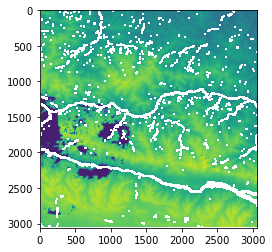

In [4]:
### -- 2.water mask
dem = xdem.DEM(path_dem_aligned)         # 
water_jrc = xdem.DEM(path_water_jrc).reproject(dem)
mask_wat = np.where(water_jrc.data[0]==0, 1, 0)  # stable region
dem_masked=np.copy(dem.data[0]); dem_masked[mask_wat ==0] = np.nan
# dem_masked[np.isnan(dem_masked)] = 0
plt.imshow(dem_masked)


In [5]:
### Read one-tile/one-year ATL06 data
with h5py.File(path_atl06, 'r') as f_atl06_tile:
    atl06_lat_tile   = f_atl06_tile['h_lat'][:]
    atl06_lon_tile   = f_atl06_tile['h_lon'][:]
    atl06_h_tile = f_atl06_tile['h_li'][:]
    atl06_t_tile = f_atl06_tile['t_dyr'][:]
    print(f_atl06_tile.keys())


<KeysViewHDF5 ['beam_type', 'cycle', 'h_lat', 'h_li', 'h_lon', 'orbit_type', 'rgt', 'spot', 't_dyr']>


In [6]:
_, dem_info = readTiff(path_dem_aligned)

### --- icesat filter by using mask image
def icesat_mask(lon, lat, h, mask, mask_geotrans):
    row, col = geo2imagexy(x=lon, y=lat, gdal_trans=mask_geotrans, integer=False)
    idx_in = np.where((row<mask.shape[0]) & (col<mask.shape[1]))[0]
    row_, col_, h_ = row[idx_in], col[idx_in], h[idx_in]    
    icesat_mask = mask[row_.astype('int'), col_.astype('int')]
    valid_idx = np.where((icesat_mask==1))[0]
    row_, col_, h_ = row_[valid_idx], col_[valid_idx], h_[valid_idx]
    return row_, col_, h_
    
atl06_row_tile_, atl06_col_tile_, atl06_h_tile_ = icesat_mask(atl06_lon_tile, \
                                    atl06_lat_tile, atl06_h_tile, mask_wat, dem_info['geotrans'])


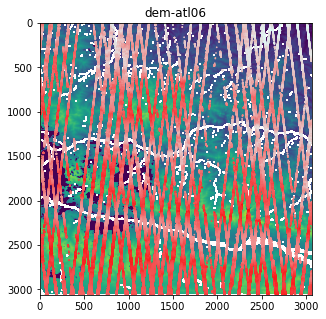

In [7]:
## visualize
cmap = LinearSegmentedColormap.from_list('linear color', ['LightCyan', 'Red'])
plt.figure(figsize=(5, 5))
plt.imshow(dem_masked, vmin=2000, vmax=7000); plt.title('dem-atl06')
plt.scatter(x=np.floor(atl06_col_tile_), y=np.floor(atl06_row_tile_), c=atl06_h_tile_, s=0.5, cmap=cmap)


In [8]:
### 1) filter out the outlier data and 2) statistic before interpolation
atl06_dem_dif = atl06_h_tile_ - dem_masked[np.floor(atl06_row_tile_).astype('int'), \
                                                        np.floor(atl06_col_tile_).astype('int')]
idx_valid = np.where((atl06_dem_dif<100) & (atl06_dem_dif > -100))   ## remove the points of h_dif<-100 and h_dif>100 
# idx_valid =  np.where((atl06_dem_dif>np.nanpercentile(atl06_dem_dif, 5)) & (atl06_dem_dif<np.nanpercentile(atl06_dem_dif, 95)))
atl06_row_tile_valid, atl06_col_tile_valid, atl06_h_tile_valid, atl06_dem_dif_valid = \
        atl06_row_tile_[idx_valid], atl06_col_tile_[idx_valid], atl06_h_tile_[idx_valid], atl06_dem_dif[idx_valid]
global_median = statistics.median(atl06_dem_dif_valid)
global_var = statistics.variance(atl06_dem_dif_valid.astype('float64'))
### assign median to global region.
dem_dif_map = np.zeros_like(dem_masked)
dem_dif_map[:,:] = global_median
print('global dem dif median:', global_median)
print('global dem dif variance:', global_var)



global dem dif median: 0.4453125
global dem dif variance: 446.7793384456563


Text(0.5, 1.0, 'difference points distribution.')

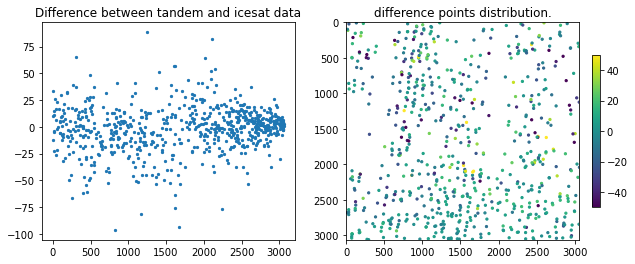

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.scatter(atl06_row_tile_valid[::600], atl06_dem_dif_valid[::600],s=5)
plt.title('Difference between tandem and icesat data')
plt.subplot(1,2,2)
cax=plt.scatter(x=atl06_col_tile_valid[::600], y=atl06_row_tile_valid[::600], \
                                        c=atl06_dem_dif_valid[::600], s=5, vmax=50, vmin=-50)
plt.xlim([0, dem_masked.shape[1]]);  plt.ylim([dem_masked.shape[0], 0])
cbar=plt.colorbar(cax,fraction=0.03)
plt.title('difference points distribution.')


### **Crop image into multiple local regions**


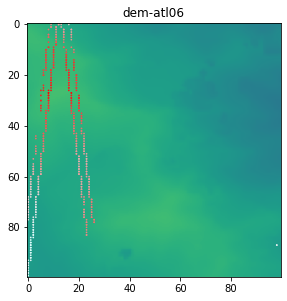

In [10]:
## check the local region and the related icesat data.
i_row_global_0, i_col_global_0 = 800, 1600
size_local = 100
idx = np.where((atl06_row_tile_valid>i_row_global_0) & (atl06_row_tile_valid<i_row_global_0+size_local) & \
                          (atl06_col_tile_valid>i_col_global_0) & (atl06_col_tile_valid<i_col_global_0+size_local))
atl06_row_local = atl06_row_tile_valid[idx]-i_row_global_0
atl06_col_local = atl06_col_tile_valid[idx]-i_col_global_0
atl06_h_local = atl06_h_tile_valid[idx]

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(dem_masked[i_row_global_0:i_row_global_0+size_local, \
                            i_col_global_0:i_col_global_0+size_local], vmin=2000, vmax=7000); 
plt.title('dem-atl06')
plt.scatter(x=np.floor(atl06_col_local), y=np.floor(atl06_row_local), c=atl06_h_local, s=0.5, cmap=cmap)

In [24]:
def dem_dif_infer(dem_global, row_icesat, col_icesat, h_icesat, size_local=100, overlay=30):
  # size_local = 100; overlay=30;
  n_row_local = dem_global.shape[0]/(size_local-overlay)
  n_col_local = dem_global.shape[1]/(size_local-overlay)
  n_regions=0
  for i_row_local in range(np.ceil(n_row_local).astype('int')):
    for i_col_local in range(np.ceil(n_col_local).astype('int')):
      n_regions+=1
      ## local pixels corresponding to the global image. 
      i_row_global_0, i_col_global_0 = i_row_local*(size_local-overlay), i_col_local*(size_local-overlay)
      i_row_global_1, i_col_global_1 = i_row_global_0+size_local, i_col_global_0+size_local
      ## select icesat data corresponding to local region, and convert the index to local coordinate
      idx = np.where((row_icesat>i_row_global_0) & (row_icesat<i_row_global_0+size_local) & \
                                (col_icesat>i_col_global_0) & (col_icesat<i_col_global_0+size_local))
      row_icesat_local = row_icesat[idx]-i_row_global_0
      col_icesat_local = col_icesat[idx]-i_col_global_0
      h_icesat_local = h_icesat[idx]
      ## calculate the dem difference of the local region. 
      if h_icesat_local.shape[0] > 20:
        dif_icesat_dem_l = h_icesat_local - dem_global[row_icesat[idx].astype('int'), \
                                                            col_icesat[idx].astype('int')]
        local_median = statistics.median(dif_icesat_dem_l)
        local_var = statistics.variance(dif_icesat_dem_l.astype('float64'))
        if local_var < global_var:
          dem_dif_map[i_row_global_0:i_row_global_0+size_local, i_col_global_0:i_col_global_0+size_local] = local_median
  print('number of local regions:',n_regions)
  return dem_dif_map

dem_dif_map = dem_dif_infer(dem_global=dem_masked, row_icesat=atl06_row_tile_valid, \
                  col_icesat=atl06_col_tile_valid, h_icesat=atl06_h_tile_valid, size_local=50, overlay=30)

dem_dif_map.shape



number of local regions: 23716


(3061, 3061)

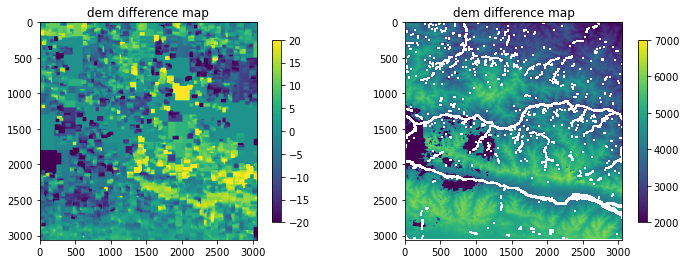

In [25]:
dem_masked_correct = dem_masked + dem_dif_map
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
cax = plt.imshow(dem_dif_map, vmax=20,vmin=-20)
plt.title('dem difference map')
plt.colorbar(cax,fraction=0.03)
plt.subplot(1,2,2)
cax = plt.imshow(dem_masked_correct, vmax=7000, vmin=2000)
plt.title('dem difference map')
plt.colorbar(cax, fraction=0.03)


### Statistic after dem correction

In [26]:
### 1) filter out the outlier data and 2) statistic before interpolation 
atl06_dem_dif_valid_correct = atl06_h_tile_valid - dem_masked_correct[np.floor(atl06_row_tile_valid).astype('int'), \
                                                      np.floor(atl06_col_tile_valid).astype('int')]
global_median_cor = statistics.median(atl06_dem_dif_valid_correct)
global_var_cor = statistics.variance(atl06_dem_dif_valid_correct.astype('float64'))
print('global dem dif median:', global_median)
print('global dem dif variance:', global_var)
print('corrected global dem dif median:', global_median_cor)
print('corrected global dem dif variance:', global_var_cor)


global dem dif median: 0.4453125
global dem dif variance: 446.7793384456563
corrected global dem dif median: -0.39941406
corrected global dem dif variance: 372.8190405206528
